# Import Libraries

In [44]:
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

### From sklearn - Preprocesing 
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Dimension reduction 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Clustering 
from sklearn.manifold import TSNE

from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics 

-----
# Reading files and merging features with labels

In [45]:
#dataset = pd.read_csv("Genes\data.csv")
dataset = pd.read_csv('/Users/pedrorodriguezdeledesmajimenez/1_Coding/Datasets/RUG_Pattern-recognition_Assignment-2/Task 1/Genres/data.csv')

#labels = pd.read_csv("Genes\labels.csv")
dataset_labels =pd.read_csv('/Users/pedrorodriguezdeledesmajimenez/1_Coding/Datasets/RUG_Pattern-recognition_Assignment-2/Task 1/Genres/labels.csv')

In [46]:
# Merging both datasets and removing first column
dataset = pd.merge(dataset, dataset_labels, on='Unnamed: 0').drop("Unnamed: 0", axis=1)

In [47]:
print(f'Dataset consists of {dataset.shape[0]} input sample vectors, each vector has {dataset.shape[1]} '\
      f'gene features.\nAlso the availbale classes are {len(dataset["Class"].unique())}.'\
      f' The possible choises are {", ".join(val for val in dataset.Class.unique())}.')
class_counts = dataset.Class.value_counts()
print(f'As we can see, we have class imbalance.\n\n{class_counts.to_string()}')

Dataset consists of 801 input sample vectors, each vector has 20532 gene features.
Also the availbale classes are 5. The possible choises are PRAD, LUAD, BRCA, KIRC, COAD.
As we can see, we have class imbalance.

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78


----
# Analizing data

### Visualization of the data before removing outliers and normalizing

We will use the "T-distributed stochastic neighbor embedding algorithm" to visualize
the high-dimensional data in a 2-D space

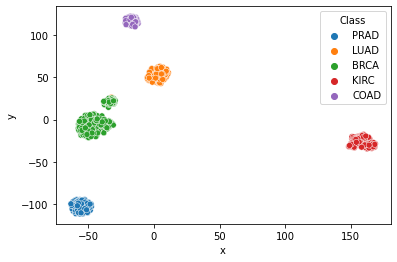

In [48]:
m = TSNE(init = 'pca', n_components = 2, learning_rate=20)
tsne_features = m.fit_transform(dataset.drop('Class', axis=1))

#Here we add the 2 new coordinate for each xample
dataset.loc[:,'x'] = tsne_features[:,0]
dataset.loc[:,'y'] = tsne_features[:,1]

#Plot the xample in 2-D
sns.scatterplot(x="x", y="y", hue='Class', data=dataset)
plt.show()

In [49]:
# We remove the 2 columns with the coordinates for representing the high dimension data in 2D
dataset.drop(['x', 'y'], axis=1, inplace=True)

###  Encode the labels of the dataset

In [50]:
# Encode the labels and updaate values
le = preprocessing.LabelEncoder()
dataset["Class"] = le.fit_transform(dataset_labels.drop("Unnamed: 0", axis=1).values.ravel())

In [51]:
# Let´s store all the labels
keys = le.classes_

# And now store labels with their encoded value 
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
dictionary

{'BRCA': 0, 'COAD': 1, 'KIRC': 2, 'LUAD': 3, 'PRAD': 4}

### Normalize the dataset

In [52]:
# Lets store the dataset values without the columns titles
x = dataset.iloc[:, :-1].values 

In [53]:
# Let´s create an instance with the normalice function
min_max_scaler = preprocessing.MinMaxScaler()

# Let´s fit the normilice function
x_scaled = min_max_scaler.fit_transform(x)

# Let´s put in the dataframe the values scaled
dataset.iloc[:, :-1] = pd.DataFrame(x_scaled)

### t-SNE After normalizing 

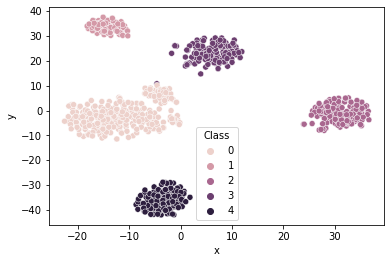

<Figure size 720x720 with 0 Axes>

In [54]:
m = TSNE(init = 'pca', n_components = 2, learning_rate=20)
tsne_features = m.fit_transform(dataset.drop('Class', axis=1))

#Here we add the 2 new coordinate for each xample
dataset.loc[:,'x'] = tsne_features[:,0]
dataset.loc[:,'y'] = tsne_features[:,1]

#Plot the xample in 2-D
sns.scatterplot(x="x", y="y", hue='Class', data=dataset)
plt.figure(figsize=(10,10))
plt.show()


In [81]:
# We remove the 2 columns with the coordinates for representing the high dimension data in 2D
dataset.drop(['x', 'y'], axis=1, inplace=True)

### Search for outliers in dataset

In [55]:
dataset.iloc[:,:-1].shape

(801, 20533)

In [56]:
lof = LocalOutlierFactor()
# fit_predict return a numpy array of 1 if not an outlier and -1 if an outlier
outliers = lof.fit_predict(dataset.iloc[:,:-1])

In [57]:
# select all rows that are not outliers
mask = outliers != -1
dataset.shape

(801, 20534)

In [58]:
#unpack the mask to keep only non-outlier examples
dataset = dataset[[*mask]]

In [59]:
print(f'Data size after removing outliers is: {dataset.shape}.')

Data size after removing outliers is: (796, 20534).


# Clustering original data: KMEANS

In [60]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [61]:
X_df = dataset.drop("Class", axis=1)
X = X_df.values

<function matplotlib.pyplot.show(close=None, block=None)>

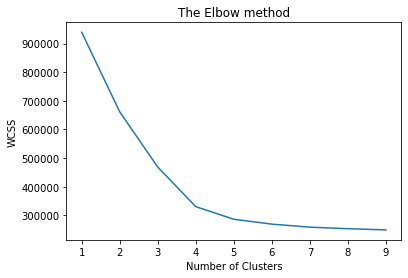

In [62]:
wcss=[]

for i in range(1,10):

    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = 300, n_init=10, random_state=2)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10),wcss)
plt.title('The Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show



In [63]:
# For nº cluster = nº categories

kmeans = KMeans(n_clusters=5, init = 'k-means++', max_iter = 300, n_init=10, random_state=2)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=2)

In [64]:
clusters_labels_kmean = kmeans.labels_

dataset_lalels_encoded = dataset["Class"].values

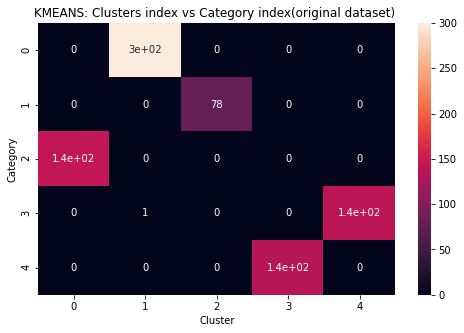

In [65]:
#Confusion matrix: informative, to see in each cluster the amount of points of each category

plt.figure(figsize=(8,5))
confusion_matrix = pd.crosstab(dataset_lalels_encoded, clusters_labels_kmean, rownames=['Category'], 
                               colnames=['Cluster'])

sns.heatmap(confusion_matrix, annot=True)
#plt.savefig("Confusion_Matrix_Kmeans.png")
plt.title('KMEANS: Clusters index vs Category index(original dataset) ')
plt.show()

### Evaluation of the clustering with Silhouette


In [66]:
from sklearn.metrics import silhouette_samples, silhouette_score

For n_clusters = 6 The average silhouette_score is : 0.3136729892738625


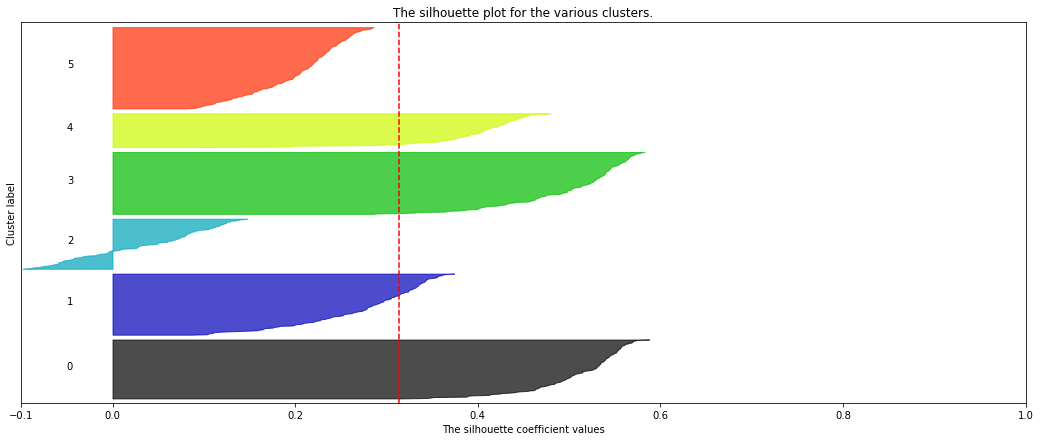

In [67]:
# Silhouete socre for different clusters 

range_n_clusters = [6]#[4, 5, 6,7]

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1,1)
    fig.set_size_inches(18, 7)
    
     # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
     # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels_2 = clusterer.fit_predict(X)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels_2)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels_2)
    
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels_2 == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.savefig("Silhouette.png")
plt.show()

-----------
## Dimensionality reduction:  Linear Discriminant Analysis


In [113]:
n_components_LDA =4

# Define transform
lda = LinearDiscriminantAnalysis(n_components=n_components_LDA)

# Apply PCA in input vector
lda.fit(dataset.iloc[:,:-1],dataset.iloc[:,-1:].values.ravel()) 

# apply transform to dataset
reduced_lda = lda.transform(dataset.iloc[:,:-1].values)
reduced_lda.shape

(796, 4)

In [114]:
# Save labels in an np.array
y_lda = dataset['Class'].to_numpy()
# apply transform to dataset
reduced_lda = lda.transform(dataset.iloc[:,:-1].values)
reduced_lda.shape

(796, 4)

In [115]:
# Create final dataframe with reduced dimensions
dataset_reduced_LDA = pd.DataFrame(np.column_stack((reduced_lda, y_lda)))
dataset_reduced_LDA.rename(columns = {n_components_LDA: 'Label'}, inplace=True)

In [116]:
dataset_reduced_LDA.head()

,0,1,2,3,Label
0,-8.179250,-10.990670,1.923807,0.583537,4.0
1,-0.309773,2.860503,-3.986629,-7.957477,3.0
2,-7.187733,-10.311444,3.515797,-0.374297,4.0
3,-2.672219,4.828713,2.912493,2.183071,0.0
4,-8.511667,-11.663387,2.189177,1.065183,4.0


------------

# Clustering reduced data: KMEANS

In [117]:
X_df = dataset_reduced_LDA.drop("Label", axis=1)
X = X_df.values

<function matplotlib.pyplot.show(close=None, block=None)>

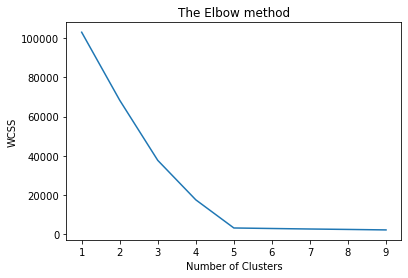

In [118]:
wcss=[]

for i in range(1,10):

    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = 300, n_init=10, random_state=2)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10),wcss)
plt.title('The Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show



In [119]:
# For no cluster = no categories

kmeans = KMeans(n_clusters=5, init = 'k-means++', max_iter = 300, n_init=10, random_state=2)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=2)

In [120]:
clusters_labels_kmean = kmeans.labels_

dataset_lalels_encoded = dataset_reduced_PCA["Label"].values

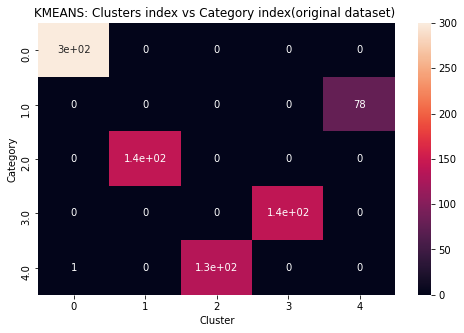

In [121]:
#Confusion matrix

plt.figure(figsize=(8,5))
confusion_matrix = pd.crosstab(dataset_lalels_encoded, clusters_labels_kmean, rownames=['Category'], 
                               colnames=['Cluster'])

sns.heatmap(confusion_matrix, annot=True)
#plt.savefig("Confusion_Matrix_Kmeans.png")
plt.title('KMEANS: Clusters index vs Category index(original dataset) ')
plt.show()

### Evaluation of the clustering with Silhouette


In [122]:
from sklearn.metrics import silhouette_samples, silhouette_score

For n_clusters = 4 The average silhouette_score is : 0.7260696371695948
For n_clusters = 5 The average silhouette_score is : 0.8343139454092603
For n_clusters = 6 The average silhouette_score is : 0.7662818093780008


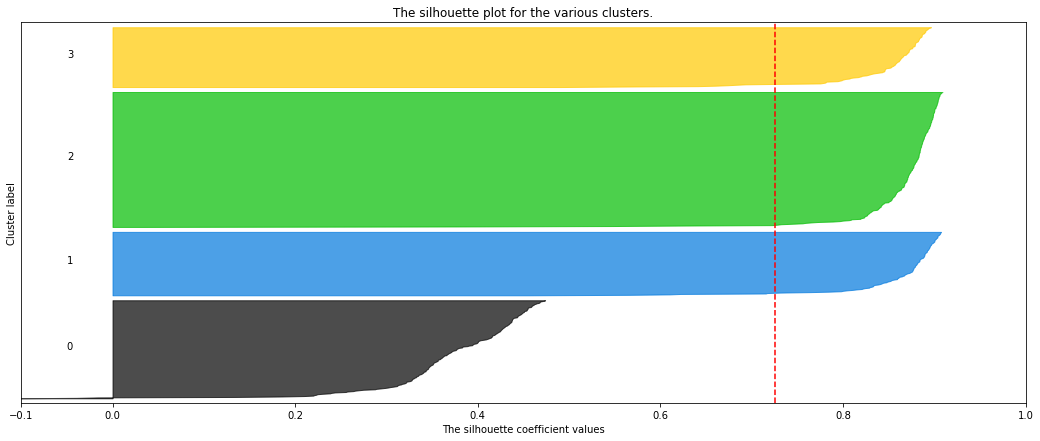

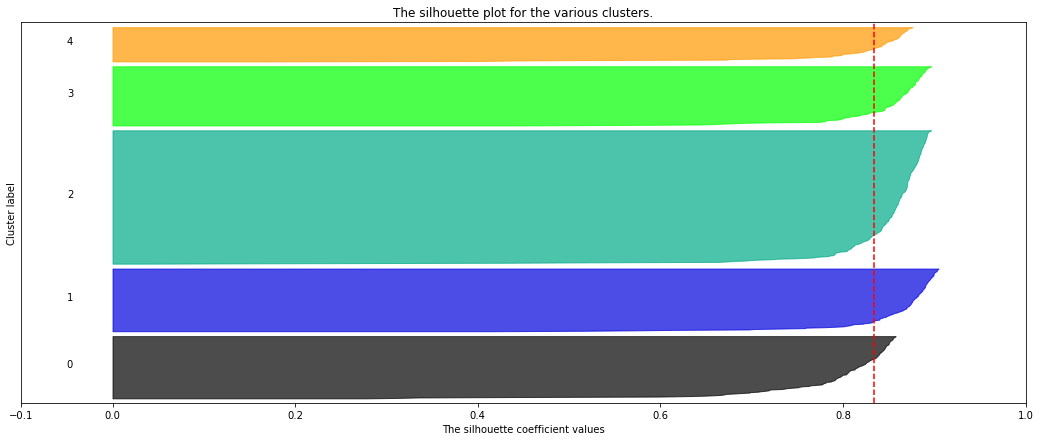

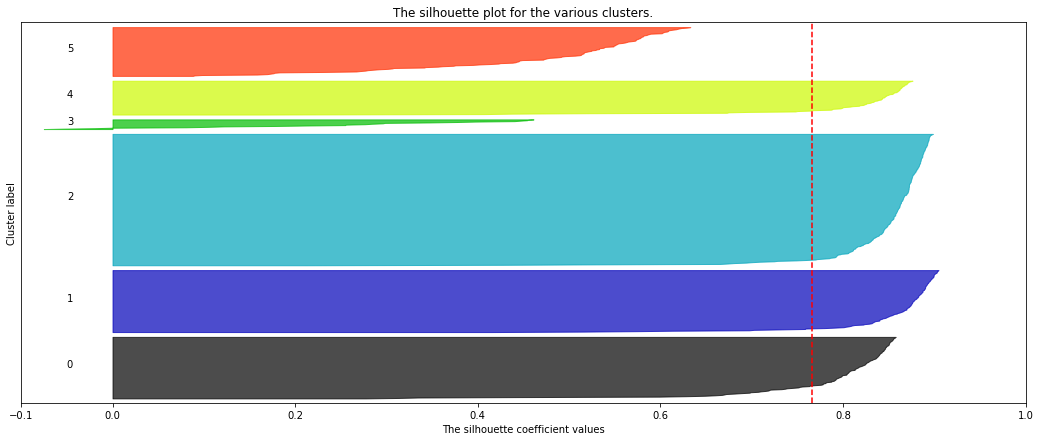

In [124]:
# Silhouete socre for different clusters 

range_n_clusters = [4, 5, 6]

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1,1)
    fig.set_size_inches(18, 7)
    
     # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
     # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels_2 = clusterer.fit_predict(X)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels_2)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels_2)
    
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels_2 == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        
plt.show()